# HVAC Hybrid Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

np.random.seed(42)

In [ ]:
hvac_data = pd.read_csv('hvac_model_zones.csv')
print('HVAC Data Shape:', hvac_data.shape)
hvac_data.head()

HVAC Data Shape: (52561, 34)


,b'Environment:Site Outdoor Air Relative Humidity[%]',b'Environment:Site Outdoor Air Dewpoint Temperature[C]',b'Electricity:HVAC[J]',b'Environment:Site Outdoor Air Wetbulb Temperature[C]',b'CLASSROOM_BOT ZN:Zone People Occupant Count[]',b'CONFROOM_BOT_1 ZN:Zone People Occupant Count[]',b'CONFROOM_BOT_2 ZN:Zone People Occupant Count[]',b'CONFROOM_MID_1 ZN:Zone People Occupant Count[]',b'CONFROOM_MID_2 ZN:Zone People Occupant Count[]',b'CONFROOM_TOP_1 ZN:Zone People Occupant Count[]',...,b'OPENOFFICE_MID_1 ZN:Zone People Occupant Count[]',b'OPENOFFICE_MID_2 ZN:Zone People Occupant Count[]',b'OPENOFFICE_MID_3 ZN:Zone People Occupant Count[]',b'OPENOFFICE_MID_4 ZN:Zone People Occupant Count[]',b'OPENOFFICE_TOP_1 ZN:Zone People Occupant Count[]',b'OPENOFFICE_TOP_2 ZN:Zone People Occupant Count[]',b'OPENOFFICE_TOP_3 ZN:Zone People Occupant Count[]',b'OPENOFFICE_TOP_4 ZN:Zone People Occupant Count[]',b'Environment:Site Day Type Index[]',b'Environment:Site Outdoor Air Drybulb Temperature[C]'
0,0.000000,0.00,0.000000e+00,0.000000,0.0,1.0,2.0,3.0,4.0,5.0,...,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,0.0,0.000000
1,83.666667,16.95,1.497632e+06,17.949119,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,19.816667
2,84.333333,16.90,5.228360e+06,17.853131,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,19.633333
3,85.000000,16.85,7.935451e+06,17.756143,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,19.450000
4,85.666667,16.80,2.509377e+06,17.658150,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,19.266667


In [3]:
hvac_data.columns = hvac_data.columns.str.replace(r"^b'|'$|\[.*?\]", "", regex=True)

In [4]:
hvac_data = hvac_data.loc[hvac_data['Environment:Site Day Type Index'] != 0]
hvac_data["HVAC_kWh"] = hvac_data["Electricity:HVAC"] * 2.77778e-7

In [5]:
occupant_cols = [col for col in hvac_data.columns if 'Occupant' in col]
hvac_data["TotalOccupantCount"] = hvac_data[occupant_cols].sum(axis=1)

In [ ]:
time_shifts = [0.5, 1, 1.5, 2]

for h in time_shifts:
    steps = int(h * 6)
    hvac_data[f"Occ_minus{int(h*60)}"] = hvac_data["TotalOccupantCount"].shift(steps)

for h in time_shifts:
    steps = int(h * 6)
    hvac_data[f"Occ_plus{int(h*60)}"] = hvac_data["TotalOccupantCount"].shift(-steps)

In [ ]:
def map_day_type(x):
    if x in [0, 6, 7]:
        return 1
    else:
        return 0

hvac_data["WeekendOrHoliday"] = hvac_data["Environment:Site Day Type Index"].apply(map_day_type)

In [ ]:
hvac_data = hvac_data.dropna()

features = ['HVAC_kWh']
target = 'HVAC_kWh'

In [9]:
def compute_metrics(test_data,forecast_mean):
    mae = mean_absolute_error(test_data, forecast_mean)
    mse = mean_squared_error(test_data, forecast_mean)
    rmse = np.sqrt(mse)


    metrics = {
        "mae":mae,
        "mse":mse,
        "rmse":rmse
    }

    return metrics

In [10]:
# split_index = len(hvac_data) - int(len(hvac_data)/53)

In [11]:
hvac_data = hvac_data[:int(len(hvac_data)/18)]
print(hvac_data.shape)

train_size = int(len(hvac_data) * 0.8)
train_data = hvac_data['HVAC_kWh'][:train_size]
test_data = hvac_data['HVAC_kWh'][train_size:]

(2918, 45)


In [12]:
X_train = np.arange(len(train_data)).reshape(-1, 1) 
y_train = train_data.values

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_fit = linear_model.predict(X_train)

residuals = y_train - y_fit

In [ ]:
lags = 5
X_resid = np.array([residuals[i - lags:i] for i in range(lags, len(residuals))])
y_resid = residuals[lags:]


xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3)
xgb_model.fit(X_resid, y_resid)

resid_predictions = xgb_model.predict(X_resid)

In [ ]:
y_fit_boosted = y_fit[lags:] + resid_predictions

In [ ]:
X_test = np.arange(len(train_data), len(train_data) + len(test_data)).reshape(-1, 1)
y_pred = linear_model.predict(X_test)

X_test_resid = np.array([test_data.values[i - lags:i] - y_pred[i - lags:i] for i in range(lags, len(test_data))])
resid_test_predictions = xgb_model.predict(X_test_resid)

y_pred_boosted = y_pred[lags:] + resid_test_predictions


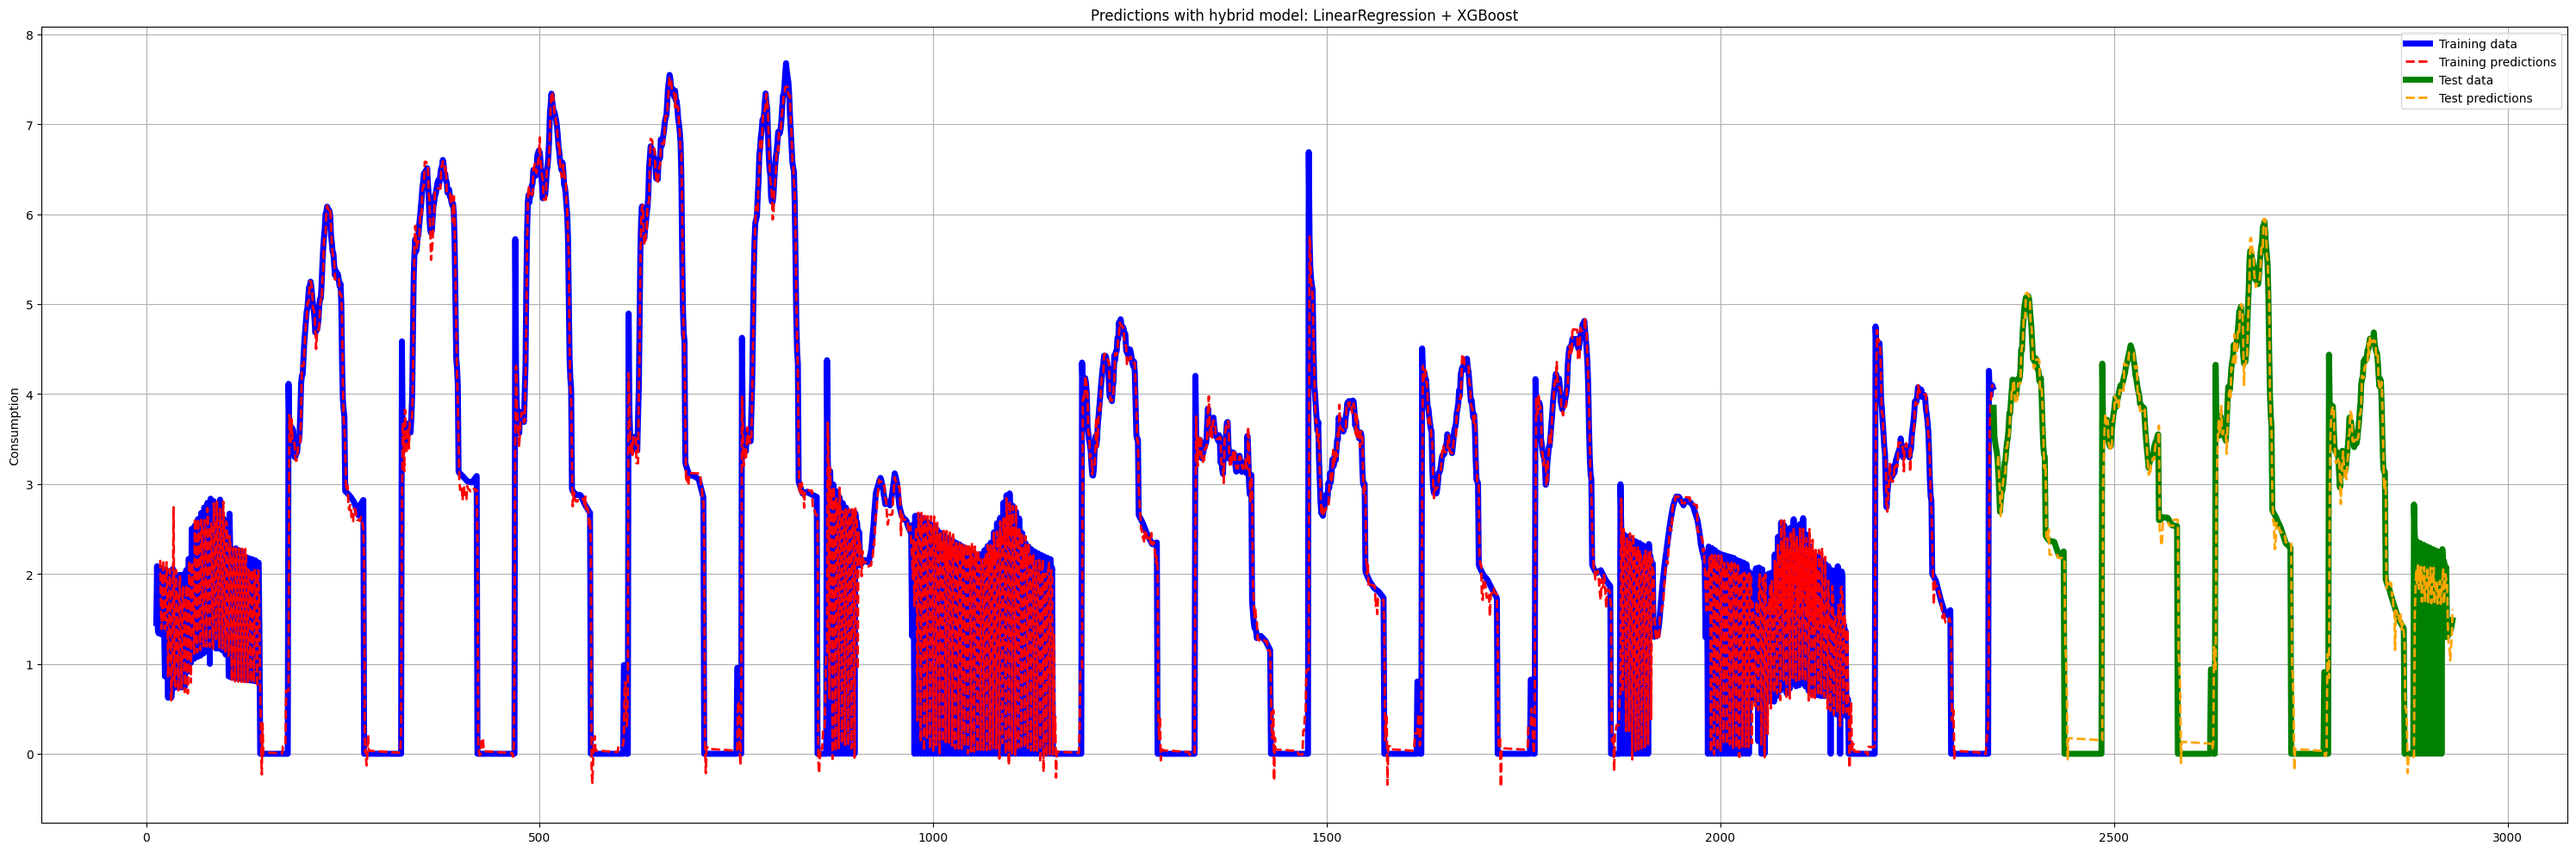

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(30, 10))

plt.plot(train_data.index, train_data, label='Training data', color='blue', linewidth=5)
plt.plot(train_data.index[-len(y_fit_boosted):], y_fit_boosted, label='Training predictions', color='red', linestyle='--', linewidth=2)

plt.plot(test_data.index, test_data, label='Test data', color='green', linewidth=5)
plt.plot(test_data.index[-len(y_pred_boosted):], y_pred_boosted, label='Test predictions', color='orange', linestyle='--', linewidth=2)

plt.legend()
plt.title('Predictions with hybrid model: LinearRegression + XGBoost')
plt.ylabel('Consumption')
plt.grid(True)
plt.tight_layout()

plt.show()

In [18]:
compute_metrics(test_data[lags:],y_pred_boosted)

{'mae': 0.2141135573876612,
 'mse': 0.236477909273323,
 'rmse': 0.48628994362758826}

How the Hybrid Model Works
Data Subsampling:
The code starts by reducing the dataset size (using only a fraction of the original data). This is often done for efficiency or to work with a representative sample of the time series.

Splitting into Training and Testing Sets:
The data is divided into training (80%) and testing (20%) sets. The model is first developed on the training data and then evaluated on the test set.

Linear Regression on the Time Series:

Purpose: Linear regression is used as a baseline to capture the primary, overall trend in the data.

Implementation:

The independent variable (X_train) is simply an array of time steps.

The dependent variable (y_train) is the HVAC energy consumption values.

A linear regression model is trained on these values.

Output:

The model produces predictions (y_fit) that reflect the linear trend.

The residuals (i.e., the differences between the actual values and the linear predictions) are computed. These residuals contain patterns not explained by the linear trend.

Modeling Residuals with XGBoost:

Purpose: Residuals often contain non-linear patterns and other complex relationships. XGBoost, a powerful gradient boosting algorithm, is used to model these residual patterns.

Implementation:

The code creates lagged features (past residual values) as inputs (X_resid) and corresponding target residuals (y_resid).

An XGBoost regressor is then trained on these features.

Output:

The XGBoost model predicts the residual component (resid_predictions), effectively capturing the non-linear aspects.

Final Predictions – Combining Both Models:

Training Set:

The final boosted predictions (y_fit_boosted) are obtained by adding the XGBoost predictions (non-linear corrections) to the original linear model predictions (excluding the first few lags).

Test Set:

A similar approach is taken: the linear regression produces predictions on the test set (y_pred), and then lagged residual features are computed from the test data.

The XGBoost model predicts the residual adjustments, and these are added to the linear predictions to form the final hybrid prediction (y_pred_boosted).

Why is This Approach Effective?
Combining Strengths:

Linear Regression:

It efficiently captures the overall, smooth trend and seasonality in time series data.

XGBoost:

It excels at capturing non-linear relationships and complex patterns that the linear model might miss.

Residual Correction:

By explicitly modeling the residuals, the hybrid approach corrects for the errors made by the linear model.

This means that after the linear trend is modeled, any remaining structure in the data (non-linearity, sudden changes, etc.) is addressed separately.

Improved Accuracy:

The combination usually leads to better forecasting performance because each model tackles the part of the problem it handles best.

This method is particularly useful when the underlying time series has both linear trends and non-linear fluctuations.

Flexibility:

The approach can be adapted to many types of time series data. If the linear model explains most of the variability, only small adjustments are needed. If non-linear effects are strong, XGBoost can capture them effectively.

